# Multi-Classification Machine Learning for Malware Analysis
## 9 Types of Malware in this dataset:
1. Ramnit         - RAT
2. Lollipop       - Adware
3. Kelihos_ver3   - RAT
4. Vundo          - Adware
5. Simda          - Botnet
6. Tracur         - Malicious Browser Plugin
7. Kelihos_ver1   - RAT
8. Obfuscator.ACY - Obfuscates other malware/information
9. Gatak          - RAT

## Game Plan:

- Look into creating more metrics to show off my model
- Improve the way I import data for the model
- Explain my code and solution in detail
- Port into the main program/script



## Imports

In [8]:
#pip install scikit-learn
#pip install seaborn
#pip install matplotlib
#pip install pandas
#pip install torch
#pip install torchvision
#pip install jupyterthemes

In [9]:
# All imports centralised here

import sys
import os
import re
import csv
import shutil
import heapq
import codecs
import json
from collections import Counter, OrderedDict, defaultdict
from pathlib import Path #Convert all directory accesses to this
from functools import reduce
import glob

import pandas as pd
import numpy as np

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.inspection import permutation_importance
from sklearn import svm
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

import pickle

pd.options.mode.chained_assignment = None  # default='warn'

## Functions

In [10]:
# Functions are all contained inside here

def createFullDirectory(mainDirectory,subDirectory):
    return str(mainDirectory+subDirectory)

def createFullPathToFile(fullDirectory, fileName):
    return str(fullDirectory+fileName)

def listFilesInDirectory(directoryContainingFiles):
    return glob.glob(directoryContainingFiles) 

def stripFilePathAndExtension(filePath, prefixToStrip, suffixToStrip):
    filePath = filePath.replace(prefixToStrip, "")
    filePath = filePath.replace(suffixToStrip, "")
    #return filePath
    return Path(filePath).stem

def replaceFilePathAndExtension(filePath, prefixToStrip, prefixToInsert, suffixToStrip, suffixToInsert):
    filePath = filePath.replace(prefixToStrip, prefixToInsert)
    filePath = filePath.replace(suffixToStrip, suffixToInsert)
    return filePath

def printDataFrame(dataframe):
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
        print(dataframe)

def zeroOutDataframe(dataframe):
    dataframe = dataframe.fillna(0)
    return dataframe

def countEntriesInDataframe(dataframe):
    return np.count_nonzero(dataframe)

def sortDictionary(dictionary):
    returnVal = sorted(dict(Counter(dictionary)).items(), key=lambda kv:
                 (kv[1], kv[0]))
    return returnVal

def fileNewlineIntoList(filePath):
    lineList = []
    with open(filePath) as openFile:
        for line in openFile:
            temp = line.strip()
            lineList.append(temp)
    return lineList

def stripNewlineAndWhitespace(textStringToStrip):
    textStringToStrip = textStringToStrip.replace("\t","")
    textStringToStrip = textStringToStrip.replace("\n","")
    textStringToStrip = textStringToStrip.replace(" ","")
    return textStringToStrip

def stripNewlineAndWhitespaceFromList(listToStrip):
    for i in range(0,len(listToStrip)):
        listToStrip[i] = listToStrip[i].replace("\t","")
        listToStrip[i] = listToStrip[i].replace("\n","")
        listToStrip[i] = listToStrip[i].replace(" ","")
    return listToStrip

def regexSearchFile(filePath, regexPattern):
    with open(filePath) as openFile:
        matches = re.findall(regexPattern, openFile.read())
    openFile.close()
    return matches

def cleanFileNameList(fileNameList,malwareClass, sortedDatasetDirectory): #NEED TO PORT THIS
    filePathToNameDict = {}
    for i in range(0, len(fileNameList)): 
        strippedFile = stripFilePathAndExtension(fileNameList[i], sortedDatasetDirectory+"/class-"+str(malwareClass)+"/", ".asm") #FIX THIS TO ALLOW FOR DIFFERENT CLASSES
        filePathToNameDict[strippedFile] = fileNameList[i]
        fileNameList[i] = strippedFile
    return fileNameList

def generateClassDataFrame(listColumnsToUse,listRowsToUse):
    return zeroOutDataframe(pd.DataFrame(columns=listColumnsToUse,index=listRowsToUse))

def moveFilesToClassFolders(backupFileList, fullFileNamesListFromCSV, unsortedDataset,sortedDataset): #Old and working before I tried the next version
    fullFileNamesListFromCSV.set_index("Id",inplace=True)
    for fileIndex in range(0,len(backupFileList)): # file is the full path to the file, fileClean is just the name of the file without extension
        fileClean = stripFilePathAndExtension(backupFileList[fileIndex],unsortedDataset,".asm")
        try:
            shutil.copyfile(backupFileList[fileIndex],sortedDataset+"class-"+str(fullFileNamesListFromCSV.loc[fileClean,"Class"])+"/"+str(fullFileNamesListFromCSV.loc[fileClean].name)+".asm")
        except:
            fileIndex = fileIndex + 1

def generateFilenameToDirectoryDict(fileDirectory):
    filePathToNameDict = {}
    for file in fileDirectory:
        filePathToNameDict[Path(file).stem] = file
    return filePathToNameDict

def populateMalwareDataframe(fileDirectoryTopLevel,instructionList):

    filePathToNameDict = generateFilenameToDirectoryDict(listFilesInDirectory(fileDirectoryTopLevel))
    dataFrame = zeroOutDataframe(pd.DataFrame(columns=instructionList,index=filePathToNameDict.keys()))

    for file in filePathToNameDict.keys(): # Go through every file in our directory
        fileDirectory = filePathToNameDict[file] # Convert using dict here
        instructionsForThisFile = stripNewlineAndWhitespaceFromList(regexSearchFile(fileDirectory,"(?:\t{3,7}       (?!db|dd)[a-zA-Z]{2,6} {1,})")) # cleaning and pulling instructions

        pandasSeriesTest = pd.Series(instructionsForThisFile).value_counts().index, pd.Series(instructionsForThisFile).value_counts().values # Counting each instruction up   
        for i in range(0, len(pandasSeriesTest[0])):
            dataFrame.loc[file,pandasSeriesTest[0][i]] = pandasSeriesTest[1][i]  #0 = instruction and 1 = count columns ||| Second value is index within that column
        
        #Optional cleaning options for my DF to merge dupe columns and group them up
        dataFrame = dataFrame.groupby(axis=1, level=0).sum() # Merges dupe columns
        #dataFrame = dataFrame.loc[:, (dataFrame != 0).any(axis=0)] # Removes columns with no values
    return dataFrame

def classDataFrameCompletion(instructionList,sortedDataset,classList,classInteger):
    print(sortedDataset+classList[classInteger-1]+"/*.asm")

    
    dataFrameInFunction = generateClassDataFrame(
        instructionList,      # This is the instruction list
        cleanFileNameList(    # This is the list of files
            listFilesInDirectory(sortedDataset+classList[classInteger-1]+"/*.asm"),  # This is the directory containing the files
            classInteger,
            sortedDataset))  #This is the malware class for cleanFileNameList
    
    dataFrameInFunction = populateMalwareDataframe(
                            sortedDataset+classList[classInteger-1]+"/*.asm",
                            instructionList)

    dataFrameInFunction = zeroOutDataframe(dataFrameInFunction)
    
    dataFrameInFunction.loc[~(dataFrameInFunction==0).all(axis=1)]
    
    dataFrameInFunction.insert(0,"class",classInteger)

    print(sortedDataset+classList[classInteger-1]+"/*.asm")

    return dataFrameInFunction

def removeNanValuesFromDataframe(dataframeToSanitise):
    dataframeToSanitise = dataframeToSanitise.replace(np.nan,0)
    return dataframeToSanitise

def normaliseData(dataframeToNormalise):
    #return (data -trainStats["mean"]) / trainStats['std'] #Works fine, experimenting with the OTHER
    #return data.div(data.sum(axis=1), axis=0)

    dataframeToNormalise = removeNanValuesFromDataframe(dataframeToNormalise)
    return dataframeToNormalise
    
def modelSVMClassifierCreate(cValue, kernelType):
    return svm.SVC(C=cValue, kernel=kernelType)
    
def svmModelFit(modelToFit,trainingDataframe, trainingDatasetLabels):
    return modelToFit.fit(trainingDataframe, trainingDatasetLabels)

def svmModelPredict(modelForPrediction, dataframeToPredictWith):
    return modelForPrediction.predict(dataframeToPredictWith)

def trainAndPredictModel(cValue, kernelType, trainingDataframe, trainingLabels):
    model = modelSVMClassifierCreate(cValue, kernelType)
    model = svmModelFit(model, trainingDataframe, trainingLabels)
    modelPrediction = svmModelPredict(model, trainingDataframe)
    return modelPrediction, model

def createSVMConfusionMatrix(predictResults, fileClassList):

    for i in range(0, len(fileClassList)): fileClassList[i] = fileClassList[i][-1]#; fileClassList[i] = int(fileClassList[i])

    ax = plt.subplot()
    cm = confusion_matrix(predictResults,predictResults)

    ax.set_xlabel("Predicted Labels") # Doesn't work
    ax.set_ylabel("True Labels") # Doesn't work
    ax.set_title("Confusion Matrix - Linear")

    sns.heatmap(cm, annot=True, ax=ax, yticklabels=fileClassList, xticklabels=fileClassList); #Semicolon removes the annoying text above the graph

def classificationReportGenerateGraph(testLabels,svmTestDatasetPrediction):
    classificationReportDF = pd.DataFrame(classification_report(testLabels,svmTestDatasetPrediction,output_dict=True)).transpose()[:9]
    classificationReportF1Supp = classificationReportDF
    classificationReportF1Supp = classificationReportF1Supp[classificationReportF1Supp.columns[2:4]]
    classificationReportF1Supp["support"] = classificationReportF1Supp["support"].astype(int).div(100)

    fig = plt.figure()
    ax = fig.add_subplot(111)

    ax.bar(
        x=classificationReportF1Supp.index.values.tolist(), 
        height=classificationReportF1Supp["f1-score"], 
        width=0.5, 
        align='center')

    ax.bar(
        x=classificationReportF1Supp.index.values.tolist(), 
        height=classificationReportF1Supp["support"], 
        width=0.35, 
        align='center')

    f1ScoreBar = mpatches.Patch(color='blue', label="f1 score")
    supportScoreBar = mpatches.Patch(color='orange', label="support")
    ax.legend(handles=[f1ScoreBar, supportScoreBar],bbox_to_anchor=(0.5, -0.055), loc="upper center",ncol=2)
    ax.set_title("A graph demonstrating the relationship between F1 scores and support")

    plt.tight_layout()
    plt.show()

def permutationImportanceGraphPlot(model, normalisedTrainDF, trainLabels):
    permutationImportance = permutation_importance(model, normalisedTrainDF, trainLabels)
    featuresList = np.array(list(normalisedTrainDF.columns))
    sortedIDX = permutationImportance.importances_mean.argsort()
    mostImportantIndexesPermutation = [list(permutationImportance.importances_mean[sortedIDX]).index(i) for i in heapq.nlargest(30, permutationImportance.importances_mean[sortedIDX])]

    ### Showing the largest features
    newFeaturesList = []
    newPermutationImportanceList = []

    for i in mostImportantIndexesPermutation[::-1]:
        newFeaturesList.append(featuresList[sortedIDX][i])
        newPermutationImportanceList.append(permutationImportance.importances_mean[sortedIDX][i])

    occurancesQuantity={}
    for i in newFeaturesList[::-1]:
        occurancesQuantity.update({i:str(int(finalDF[i].mean()))})


    from sklearn import preprocessing
    plt.subplot(1, 2, 1)
    plt.barh(newFeaturesList, newPermutationImportanceList);
    plt.xlabel("Permutation Importance/Feature");
    plt.margins(x=0)
    plt.xticks([0,0.1,0.2,0.3,0.4,0.5],["0","0.2","0.4","0.6","0.8","1"])

    plt.subplot(1, 2, 2)
    plt.barh(list(occurancesQuantity.keys())[::-1], preprocessing.minmax_scale(list(occurancesQuantity.values())[::-1],feature_range=(0,0.5)));
    plt.xlabel("Mean Relative occurances/Feature");
    plt.xticks([0,0.1,0.2,0.3,0.4,0.5],["0","0.2","0.4","0.6","0.8","1"])
    plt.margins(x=0)
    plt.tight_layout()


## Defining Directories and required structures

In [11]:
# Directory structures are defined here

baseDirectory = "/home/eddy/finalyearproject/machine-learning/data/"
classList = ["class-1","class-2","class-3","class-4","class-5","class-6","class-7","class-8","class-9"]
unsortedDataset = createFullDirectory(baseDirectory,"dataset-training-full-sanitised/")
sortedDataset = createFullDirectory(baseDirectory,"dataset-training-subset-sorted/")

## Pulling the files from the dataset into the class folders

In [12]:
# Moving files from the santised but unsorted folder into the sanitised and sorted folder

#moveFilesToClassFolders(listFilesInDirectory(unsortedDataset+"*"),pd.read_csv("/home/eddy/machine-learning/data/trainLabels.csv"),unsortedDataset,sortedDataset)

### Making sure there are less than 250 files in each class

In [13]:
# Deleting all but 250 files in each class

for fileClass in classList:
    directory = str(sortedDataset+fileClass+"/*")
    fileList = listFilesInDirectory(directory) #glob.glob(directory)

    print(fileClass)
    print(len(fileList))

    i = 0
    for i in range(0,len(fileList)):
        if(i >= 250):
            os.remove(fileList[i])
    print(len(listFilesInDirectory(sortedDataset+classList[0]+"/*.asm")))


class-1
250
250
class-2
250
250
class-3
250
250
class-4
250
250
class-5
42
250
class-6
250
250
class-7
250
250
class-8
250
250
class-9
250
250


## Creating the Pandas DataFrame for the malware classes

In [14]:
# Creating a Dataframe for each of the classes

instructionList = fileNewlineIntoList("/home/eddy/finalyearproject/machine-learning/instructionListComplete.txt")
instructionList = [instruction.lower() for instruction in instructionList] # Making all instructions lowercase

dataframeClassOne = classDataFrameCompletion(instructionList, sortedDataset, classList, 1)
dataframeClassTwo = classDataFrameCompletion(instructionList, sortedDataset, classList, 2)
dataframeClassThree = classDataFrameCompletion(instructionList, sortedDataset, classList, 3)
dataframeClassFour = classDataFrameCompletion(instructionList, sortedDataset, classList, 4)
dataframeClassFive = classDataFrameCompletion(instructionList, sortedDataset, classList, 5)
dataframeClassSix = classDataFrameCompletion(instructionList, sortedDataset, classList, 6)
dataframeClassSeven = classDataFrameCompletion(instructionList, sortedDataset, classList, 7)
dataframeClassEight = classDataFrameCompletion(instructionList, sortedDataset, classList, 8)
dataframeClassNine = classDataFrameCompletion(instructionList, sortedDataset, classList, 9)

/home/eddy/finalyearproject/machine-learning/data/dataset-training-subset-sorted/class-1/*.asm


/tmp/ipykernel_4739/1565671145.py:103: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataFrame.loc[file,pandasSeriesTest[0][i]] = pandasSeriesTest[1][i]  #0 = instruction and 1 = count columns ||| Second value is index within that column
/tmp/ipykernel_4739/1565671145.py:103: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataFrame.loc[file,pandasSeriesTest[0][i]] = pandasSeriesTest[1][i]  #0 = instruction and 1 = count columns ||| Second value is index within that column
/tmp/ipykernel_4739/1565671145.py:103: PerformanceWarning:

/home/eddy/finalyearproject/machine-learning/data/dataset-training-subset-sorted/class-1/*.asm
/home/eddy/finalyearproject/machine-learning/data/dataset-training-subset-sorted/class-2/*.asm


/tmp/ipykernel_4739/1565671145.py:103: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataFrame.loc[file,pandasSeriesTest[0][i]] = pandasSeriesTest[1][i]  #0 = instruction and 1 = count columns ||| Second value is index within that column
/tmp/ipykernel_4739/1565671145.py:103: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataFrame.loc[file,pandasSeriesTest[0][i]] = pandasSeriesTest[1][i]  #0 = instruction and 1 = count columns ||| Second value is index within that column
/tmp/ipykernel_4739/1565671145.py:103: PerformanceWarning:

/home/eddy/finalyearproject/machine-learning/data/dataset-training-subset-sorted/class-2/*.asm
/home/eddy/finalyearproject/machine-learning/data/dataset-training-subset-sorted/class-3/*.asm


/tmp/ipykernel_4739/1565671145.py:103: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataFrame.loc[file,pandasSeriesTest[0][i]] = pandasSeriesTest[1][i]  #0 = instruction and 1 = count columns ||| Second value is index within that column
/tmp/ipykernel_4739/1565671145.py:103: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataFrame.loc[file,pandasSeriesTest[0][i]] = pandasSeriesTest[1][i]  #0 = instruction and 1 = count columns ||| Second value is index within that column
/tmp/ipykernel_4739/1565671145.py:103: PerformanceWarning:

/home/eddy/finalyearproject/machine-learning/data/dataset-training-subset-sorted/class-3/*.asm
/home/eddy/finalyearproject/machine-learning/data/dataset-training-subset-sorted/class-4/*.asm


/tmp/ipykernel_4739/1565671145.py:103: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataFrame.loc[file,pandasSeriesTest[0][i]] = pandasSeriesTest[1][i]  #0 = instruction and 1 = count columns ||| Second value is index within that column
/tmp/ipykernel_4739/1565671145.py:103: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataFrame.loc[file,pandasSeriesTest[0][i]] = pandasSeriesTest[1][i]  #0 = instruction and 1 = count columns ||| Second value is index within that column
/tmp/ipykernel_4739/1565671145.py:103: PerformanceWarning:

/home/eddy/finalyearproject/machine-learning/data/dataset-training-subset-sorted/class-4/*.asm
/home/eddy/finalyearproject/machine-learning/data/dataset-training-subset-sorted/class-5/*.asm


/tmp/ipykernel_4739/1565671145.py:103: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataFrame.loc[file,pandasSeriesTest[0][i]] = pandasSeriesTest[1][i]  #0 = instruction and 1 = count columns ||| Second value is index within that column
/tmp/ipykernel_4739/1565671145.py:103: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataFrame.loc[file,pandasSeriesTest[0][i]] = pandasSeriesTest[1][i]  #0 = instruction and 1 = count columns ||| Second value is index within that column
/tmp/ipykernel_4739/1565671145.py:103: PerformanceWarning:

/home/eddy/finalyearproject/machine-learning/data/dataset-training-subset-sorted/class-5/*.asm
/home/eddy/finalyearproject/machine-learning/data/dataset-training-subset-sorted/class-6/*.asm


/tmp/ipykernel_4739/1565671145.py:101: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pandasSeriesTest = pd.Series(instructionsForThisFile).value_counts().index, pd.Series(instructionsForThisFile).value_counts().values # Counting each instruction up
/tmp/ipykernel_4739/1565671145.py:101: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pandasSeriesTest = pd.Series(instructionsForThisFile).value_counts().index, pd.Series(instructionsForThisFile).value_counts().values # Counting each instruction up
/tmp/ipykernel_4739/1565671145.py:101: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pandasSeriesTest = pd.Series(instructionsForThisFile).value_counts

/home/eddy/finalyearproject/machine-learning/data/dataset-training-subset-sorted/class-6/*.asm
/home/eddy/finalyearproject/machine-learning/data/dataset-training-subset-sorted/class-7/*.asm


/tmp/ipykernel_4739/1565671145.py:103: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataFrame.loc[file,pandasSeriesTest[0][i]] = pandasSeriesTest[1][i]  #0 = instruction and 1 = count columns ||| Second value is index within that column
/tmp/ipykernel_4739/1565671145.py:103: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataFrame.loc[file,pandasSeriesTest[0][i]] = pandasSeriesTest[1][i]  #0 = instruction and 1 = count columns ||| Second value is index within that column
/tmp/ipykernel_4739/1565671145.py:103: PerformanceWarning:

/home/eddy/finalyearproject/machine-learning/data/dataset-training-subset-sorted/class-7/*.asm
/home/eddy/finalyearproject/machine-learning/data/dataset-training-subset-sorted/class-8/*.asm


/tmp/ipykernel_4739/1565671145.py:101: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pandasSeriesTest = pd.Series(instructionsForThisFile).value_counts().index, pd.Series(instructionsForThisFile).value_counts().values # Counting each instruction up
/tmp/ipykernel_4739/1565671145.py:101: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pandasSeriesTest = pd.Series(instructionsForThisFile).value_counts().index, pd.Series(instructionsForThisFile).value_counts().values # Counting each instruction up
/tmp/ipykernel_4739/1565671145.py:101: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  pandasSeriesTest = pd.Series(instructionsForThisFile).value_counts

/home/eddy/finalyearproject/machine-learning/data/dataset-training-subset-sorted/class-8/*.asm
/home/eddy/finalyearproject/machine-learning/data/dataset-training-subset-sorted/class-9/*.asm


/tmp/ipykernel_4739/1565671145.py:103: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataFrame.loc[file,pandasSeriesTest[0][i]] = pandasSeriesTest[1][i]  #0 = instruction and 1 = count columns ||| Second value is index within that column
/tmp/ipykernel_4739/1565671145.py:103: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  dataFrame.loc[file,pandasSeriesTest[0][i]] = pandasSeriesTest[1][i]  #0 = instruction and 1 = count columns ||| Second value is index within that column
/tmp/ipykernel_4739/1565671145.py:103: PerformanceWarning:

/home/eddy/finalyearproject/machine-learning/data/dataset-training-subset-sorted/class-9/*.asm


In [15]:
# Constructing the Final Dataframe

dataframesList = [dataframeClassOne,dataframeClassTwo,dataframeClassThree,dataframeClassFour,dataframeClassFive,dataframeClassSix,dataframeClassSeven,dataframeClassEight,dataframeClassNine]
finalDF = pd.concat(dataframesList).drop_duplicates()
finalDF = zeroOutDataframe(finalDF)
finalDF.loc[~(finalDF==0).all(axis=1)]
finalDF = finalDF.loc[:, (finalDF != 0).any(axis=0)] # Removes columns with no values
finalDF = finalDF.sample(frac=1)
finalDF.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1803 entries, EV5y3k4OfPat2g0TAbHl to DClx6p7OIkUwVmNYajhB
Columns: 351 entries, class to vmovss
dtypes: float64(350), int64(1)
memory usage: 4.8+ MB


## Splitting the data into train+test sets

In [16]:
# Dividing up the dataset into train, validate and test sets
trainDF, testAndValidDF = train_test_split(finalDF, test_size=0.4)
testDF, validDF = train_test_split(testAndValidDF, test_size=0.5)

print(f"Training Dataset rows and columns: {trainDF.shape}")
print(f"Test Dataset rows and columns: {testDF.shape}")
print(f"Validation Dataset rows and columns: {validDF.shape}")

Training Dataset rows and columns: (1081, 351)
Test Dataset rows and columns: (361, 351)
Validation Dataset rows and columns: (361, 351)


In [17]:
# Showing training dataframe information and removing the classes to feed into the model
#trainStats = trainDF.describe()
#trainStats.pop("class")

## Training Stats

In [18]:
# Creating training stats based on the trainDF dataset
trainStats = trainDF.describe()
trainStats.pop("class")
trainStats = trainStats.transpose()
trainStats.to_csv("/home/eddy/traindata.csv")

In [19]:
# Creating Training, Validation and Testing Labels and printing the length of each
trainLabels = trainDF.pop("class")
print("Training data rows:    "+str(len(trainLabels)))

validLabels = validDF.pop("class")
print("Validation data rows:  "+str(len(validLabels)))

testLabels = testDF.pop("class")
print("Testing data rows:     "+str(len(testLabels)))

Training data rows:    1081
Validation data rows:  361
Testing data rows:     361


## Data Normalisation/Scaling

In [20]:
# Normalisation Functions happen here

normalisedTrainDF = removeNanValuesFromDataframe(normaliseData(trainDF))
normalisedValidDF = removeNanValuesFromDataframe(normaliseData(validDF))
normalisedTestDF = removeNanValuesFromDataframe(normaliseData(testDF))

normalisedTrainDF.head(10)

,aad,aam,abstr,adc,add,addpd,addps,addsd,addss,align,...,VxDJmp,cmovp,ht,loopw,retnw,svldt,vmovd,vorpd,vpcext,vmovss
fXrRBS7TvQYH2nU5wkjg,0.0,0.0,0.0,0.0,192.0,0.0,0.0,0.0,0.0,84.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9tmX2JACrdeGWHkY3fwi,0.0,0.0,0.0,2.0,123.0,0.0,0.0,0.0,0.0,166.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4gPjloRVaKb2BzGC8ukn,0.0,0.0,0.0,5.0,108.0,0.0,0.0,0.0,0.0,21.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
iIPzvDjcCXwE1y6ZFNen,4.0,1.0,0.0,8.0,389.0,0.0,0.0,0.0,0.0,65.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
dDzqka3oCtXi6WgMuZYj,0.0,1.0,0.0,3.0,311.0,0.0,0.0,0.0,0.0,65.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8J6QdyfRgIeTnFsNPKDp,0.0,0.0,0.0,1.0,465.0,0.0,0.0,0.0,0.0,153.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
HRL1PvrNMO70Gojpsexf,0.0,0.0,0.0,0.0,53.0,0.0,0.0,0.0,0.0,54.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Ju4nWgOCHXBlyZmTo51e,0.0,14.0,0.0,43.0,128.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
hcpZW5LfIklq0gCJsYTP,0.0,0.0,0.0,1.0,98.0,0.0,0.0,0.0,0.0,39.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
85rKfZbF1SIhMdjmux2N,0.0,0.0,0.0,0.0,192.0,0.0,0.0,0.0,0.0,83.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Training the model and creating a small prediction for testing

In [21]:
# SVM Classifier Object is Created

svmLinearModelPrediction, model = trainAndPredictModel(1.5, "linear", normalisedTrainDF, trainLabels)
svmValidationDatasetPrediction = svmModelPredict(model, normalisedValidDF)
svmTestDatasetPrediction = svmModelPredict(model, normalisedTestDF)

svmPolyModelPrediction, modelPoly = trainAndPredictModel(1.5, "poly", normalisedTrainDF, trainLabels)
svmRBFModelPrediction, modelRBF = trainAndPredictModel(1.5, "rbf", normalisedTrainDF, trainLabels)
svmSigmoidModelPrediction, modelSig = trainAndPredictModel(1.5, "sigmoid", normalisedTrainDF, trainLabels)

In [22]:
# Printing out the example prediction - Put this in a DF to compare labels and predicted labels

exampleSubsetDF = normalisedTestDF[:10]

exampleResult = model.predict(exampleSubsetDF)

dataFrameExampleResult = pd.Series(list(exampleSubsetDF.index),index=exampleResult)

dataFrameExampleResult.head(10)

1    iNCcGvnFJ0uqUjZYtQf5
3    16eajI7F2vQKhwi9dM4O
4    G9jfR1PvIhwMx2Wts43b
9    gDYeNAplMujwPtU0qnJW
9    4mW3JCvdzTjoRaDPK9ge
8    fiXI4tZdP6M2gKW0L1bj
8    jzUS0Eu9OKTVZFRY7Xny
7    i0nhIRJcsq6BQCpmNVlj
6    I3NCymSAn6soGWjLPvwE
1    GNx5o9mIsTV3SUkeJFgP
dtype: object

## Accuracy of training, validation and testing

In [23]:
# Accuracy for the Training Set

#normalisedTrainDF = normalisedTrainDF[np.isfinite(normalisedTrainDF).all(1)] #Testing commenting this out

print("Linear Train Accuracy: ",metrics.accuracy_score(trainLabels,svmLinearModelPrediction))
print("Linear Validation Accuracy: ",metrics.accuracy_score(validLabels,svmValidationDatasetPrediction))
print("Linear Test Accuracy: ",metrics.accuracy_score(testLabels,svmTestDatasetPrediction))

print("\nPoly Train Accuracy: ",metrics.accuracy_score(trainLabels,svmPolyModelPrediction))
print("RBF Train Accuracy: ",metrics.accuracy_score(trainLabels,svmRBFModelPrediction))
print("Sigmoid Train Accuracy: ",metrics.accuracy_score(trainLabels,svmSigmoidModelPrediction))

Linear Train Accuracy:  0.9944495837187789
Linear Validation Accuracy:  0.9168975069252078
Linear Test Accuracy:  0.9445983379501385

Poly Train Accuracy:  0.21739130434782608
RBF Train Accuracy:  0.45235892691951896
Sigmoid Train Accuracy:  0.23404255319148937


## Confusion Matrix for the model

In [24]:
# Classification Report Details
print(classification_report(testLabels,svmTestDatasetPrediction))

              precision    recall  f1-score   support

           1       0.87      0.75      0.80        44
           2       0.89      0.96      0.92        50
           3       1.00      1.00      1.00        50
           4       0.98      1.00      0.99        45
           5       0.90      1.00      0.95         9
           6       0.78      0.88      0.82        16
           7       0.98      0.98      0.98        53
           8       0.98      0.91      0.95        47
           9       0.98      1.00      0.99        47

    accuracy                           0.94       361
   macro avg       0.93      0.94      0.93       361
weighted avg       0.95      0.94      0.94       361



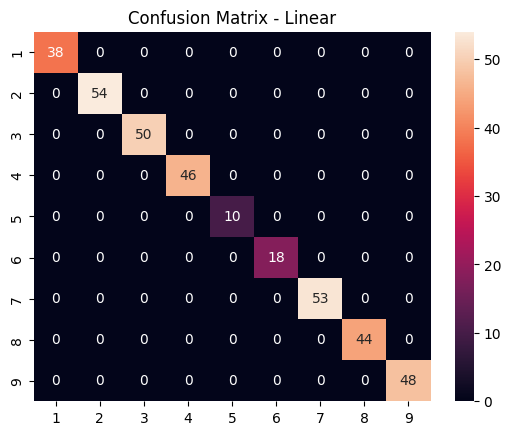

In [25]:
# Confusion Matrix Plotted and Printed Here

createSVMConfusionMatrix(svmTestDatasetPrediction,classList)

## Permutation importance stats for the model's weighting of features

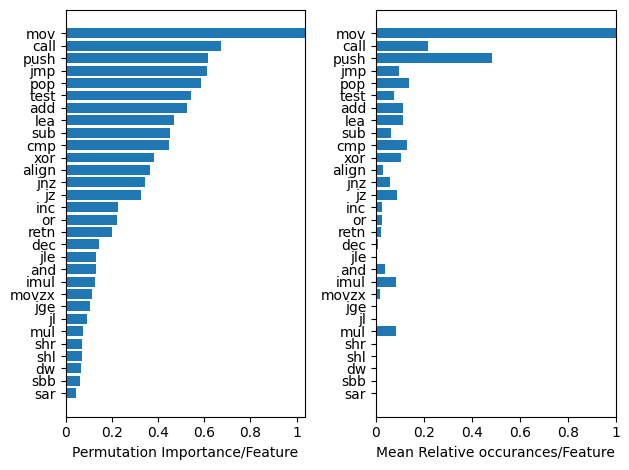

In [26]:
# Permutation Importance Graphs Plotted and Printed Here - Compare these with how many files these instructions actually occur in

permutationImportanceGraphPlot(model, normalisedTrainDF, trainLabels)

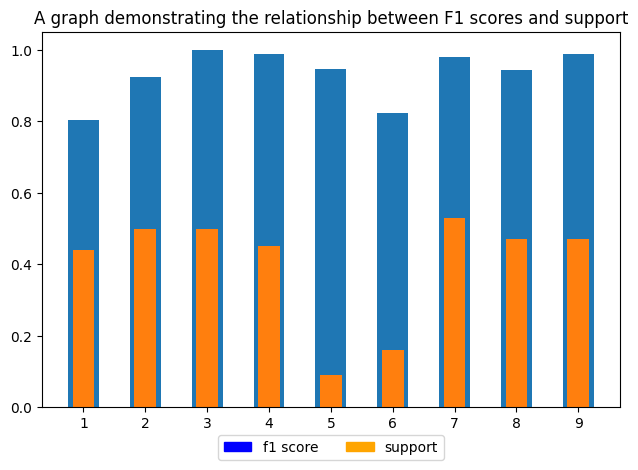

In [27]:
# Raw Classification Report stats graphed out here

classificationReportGenerateGraph(testLabels, svmTestDatasetPrediction)